In [2]:
from optimize import optimizer
from data import data_loader
from all_coefs import load_coefs
from spread import spread_manager
from revert import df_to_inv_mom,df_to_dict
from tqdm.notebook import tqdm

import datetime as dt
import pandas as pd
import numpy as np

In [3]:
data=data_loader('2024-01-01')
price_data=data.load_price()

price_dict=df_to_dict(price_data)

coef_matrix=load_coefs(data,'t025imb05corr085typestd.pkl')

spreads=spread_manager(price_data,coef_matrix)
spreads.calc_costs()
signals=spreads.raw_signal()
z_score=spreads.new_z_score()
rev=df_to_inv_mom(z_score)
filterer=spreads.signal_z_score_filter()

signal_dict=df_to_dict(signals)
rev_dict=df_to_dict(rev)
filter_dict=df_to_dict(filterer)

In [4]:
start_date=dt.datetime(2023,12,31)
end_date=dt.datetime(2025,1,1)
dates_used=data.all_dates()[(data.all_dates()>=pd.Timestamp(start_date))&(data.all_dates()<pd.Timestamp(end_date))]

In [5]:
start_dates=[]
end_dates=[]
for i in range(len(dates_used)):
    try:
        end_dates.append(dates_used[i+1])
        start_dates.append(dates_used[i])
    except:
        break

In [ ]:
#PARAMETERS
start_val=100e6

lam_1=-1
lam_2=3
lam_3=10

prog=tqdm(total=len(start_dates))

w_0=price_dict[start_dates[0]].copy()
w_0[:]=0
try:
    w_0.drop('CONST',inplace=True)
except:
    pass

w_0s=[w_0]
start_vals=[start_val]

w_1s=[]
final_vals=[]

w_trade=[]

t_costs=[]
loan_cost=[]
short_int=[]
mm_int=[]
daily_pnl=[]

net_pos=[]
tot_pos=[]
beta=[]
vol=[]

opt=optimizer(data,signal_dict,rev_dict,price_dict,filter_dict,coef_matrix)

for i in range(len(start_dates)):
    if i==0:
        pass
    else:
        w_0=w_1s[-1]
        start_val=final_vals[-1]
        w_0s.append(w_0)
        start_vals.append(start_val)
    
    t,w,betas,cov=opt.optimize(w_0,start_dates[i],lam_1=lam_1,lam_2=lam_2,lam_3=lam_3,n_epochs=101)
    t,w,betas,cov=opt.optimize(w_0,start_dates[i],lam_1=lam_1,lam_2=lam_2,lam_3=lam_3,n_epochs=101,t=t)
    t,w,betas,cov=opt.optimize(w_0,start_dates[i],lam_1=lam_1,lam_2=lam_2,lam_3=lam_3,n_epochs=101,t=t)
    t,w,betas,cov=opt.optimize(w_0,start_dates[i],lam_1=lam_1,lam_2=lam_2,lam_3=lam_3,n_epochs=101,t=t)
    t,w,betas,cov=opt.optimize(w_0,start_dates[i],lam_1=lam_1,lam_2=lam_2,lam_3=lam_3,n_epochs=101,t=t)
    t,w,betas,cov=opt.optimize(w_0,start_dates[i],lam_1=lam_1,lam_2=lam_2,lam_3=lam_3,n_epochs=101,t=t)

    a,b,c,d,e,f,g=opt.pnl.calc_pnl(start_val,end_dates[0],w_0,w,return_type='all')
    
    w_trade.append(w)
    w_1s.append(b)
    final_vals.append(a)
    t_costs.append(c)
    loan_cost.append(d)
    short_int.append(e)
    mm_int.append(f)
    daily_pnl.append(g)

    net_pos.append(np.sum(w))
    tot_pos.append(np.sum(np.abs(w)))
    beta.append(np.sum(w*betas))
    vol.append(np.sqrt(w.T@cov@w))
    prog.update(1)

  0%|          | 0/211 [00:00<?, ?it/s]

In [7]:
final_vals[-1]

101964269.69185281

In [8]:
print(np.average(net_pos))
print(np.average(tot_pos))
print(np.average(beta))
print(np.average(vol))
print(np.average(t_costs))
print(np.average(loan_cost))
print(np.average(short_int))
print(np.average(mm_int))
print(np.average(daily_pnl))

-0.06716481376590792
4.075235300857848
-0.04341261293912268
0.07974253748010833
30225.575518305683
7621.52594352642
31697.969772908593
10069.23069829293
0.5989783607616634


In [ ]:
out_data={'w_0s':pd.concat(w_0s,axis=1),
          'w_1s':pd.concat(w_1s,axis=1),
          'w_trade':pd.concat(w_trade,axis=1),
          'start_vals':start_vals,
          'final_vals':final_vals,
          't_costs':t_costs,
          'loan_cost':loan_cost,
          'short_int':short_int,
          'mm_int':mm_int,
          'daily_pnl':daily_pnl,
          'net_pos':net_pos,
          'tot_pos':tot_pos,
          'beta':beta,
          'vol':vol,
          'start_dates':start_dates,
          'end_dates':end_dates
}

In [10]:
import pickle as pkl

with open("data/Results/-1_1_10_training.pkl", "wb") as f:
    pkl.dump(out_data, f)

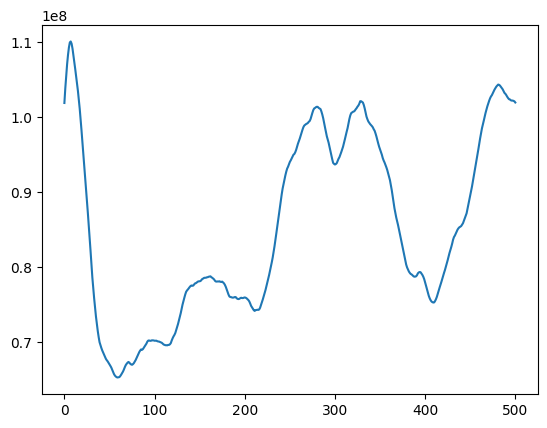

In [11]:
import matplotlib.pyplot as plt

plt.plot(final_vals)

In [14]:
pd.concat(w_1s,axis=1).to_clipboard()

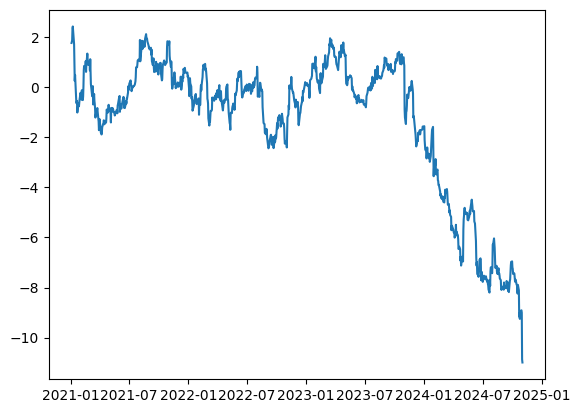

In [ ]:


plt.plot(z_score['Automobiles & Components 1'])